In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Establishing graphing parameters
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

In [ ]:
#models to try for binary classification: Log regression, SVM, Random Forests, Neural Networks

In [ ]:
#Next steps: KNN, create elbow plot and ID the right number of K
#Then impute missing data

# Load Data

In [3]:
# Read in the loan prediction train data.
loan = pd.read_csv('./Data/loan_prediction/train.csv')

# Data Exploration

In [4]:
loan.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [ ]:
#seems this is a classification problem, determining whether or not a loan is given
loan.head()

In [ ]:
loan.info()
#missing values, how will we fill?
#probably don't use complete case, not enough observations. Maybe use subset, remove all observations missing both credit history and self_employed
#MCAR: Credit_History, self_employed. Check distribution and try most frequent
#MAR: gender, married, dependents, loanAmount, loanamount_term

In [ ]:
#134 observations with some level of missing data.
loan.loc[(loan.isnull().sum(axis=1) != 0), :]

In [ ]:
#76 observations missing the two MCAR
#any correlation between missing credit history and Education
loan.loc[(loan[['Self_Employed','Credit_History']].isnull().sum(axis=1) != 0), :]

In [ ]:
#Gender is Male/Female. Consider nominal encoding
#Married is boolean (Y/N). Fill with T/F Boolean? Consider nominal encoding.
#Dependents is 0/1/2/3+. Do we need to ordinal encode into different classes?
#Education is Graduate/Not Graduate. Consider nominal encoding.
#Self_Employed is boolean (Y/N). Fill with T/F Boolean? Consider nominal encoding.
#Credit History is 1 or 0, convert to object or int field. Replace with T/F Boolean? Consider nominal encoding.
#Property_Area is Urban/Rural/Semiurban. Consider encoding. Consider nominal encoding.
#CoapplicantIncome of 0 should be considered as no coapplicant, not a missing value

{col: loan[col].unique() for col in loan.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], axis=1)}

In [ ]:
#correlation doesn't tell us much, partly because we're looking at a binary variable
corr = loan.corr().round(4)
corr['Credit_History']

In [ ]:
#skewed towards Yes, Yes twice as many as No
loan['Loan_Status'].value_counts()

In [ ]:
#Looking at outliers
sns.boxplot(x=loan['ApplicantIncome']);

In [ ]:
#Looking at outliers
sns.boxplot(x=loan['LoanAmount']);

# Prepare data for baseline model scoring

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, decomposition
from sklearn.pipeline import Pipeline

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

import warnings

In [5]:
#remove all rows missing values and create new DataFrame
#also remove Loan_ID as it has no impact on loan status
df_nonull = loan.dropna()
df_nonull = df_nonull.drop(columns='Loan_ID')

In [6]:
#Shouldnt use ordinal encoder unless it's for ordinal categorical variables. Use OneHot Econder or dummies instead.
#Dependents is the only ordinal category
df_nonull.loc[(df_nonull['Dependents']=='3+'),['Dependents']] = 3

In [7]:
#Use one hot encoder or get_dummies
#get_dummies converts NaN to 0
df_nonull = pd.get_dummies(df_nonull, columns = ['Gender','Married', 'Self_Employed','Credit_History', 'Property_Area', 'Education', 'Loan_Status'], drop_first=True)

In [ ]:
df_nonull.head()

In [8]:
X = df_nonull.drop(columns='Loan_Status_Y')
y = df_nonull['Loan_Status_Y']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=421)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((384, 12), (96, 12), (384,), (96,))

### Logistic Regression

#### Baseline

In [12]:
lgmod_base = LogisticRegression(solver = 'lbfgs', max_iter=200, random_state=421)
lgmod_base.fit(X_train, y_train)
y_base_pred = lgmod_base.predict(X_test)

In [13]:
#baseline model scores
print("Accuracy:",metrics.accuracy_score(y_test, y_base_pred))
print("Precision:",metrics.precision_score(y_test, y_base_pred))
print("Recall:",metrics.recall_score(y_test, y_base_pred))

Accuracy: 0.7708333333333334
Precision: 0.7777777777777778
Recall: 0.9402985074626866


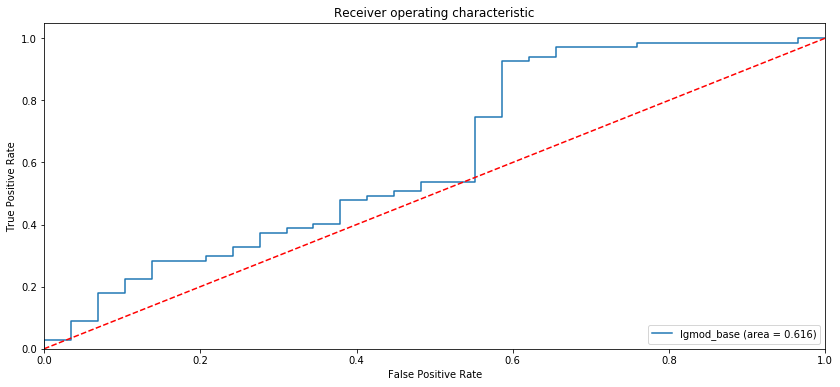

In [15]:
#area under curve for baseline. Plot of true positive rate against false positive rate
#.616 is bad
y_pred_proba = lgmod_base.predict_proba(X_test)
preds = y_pred_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr,tpr)


plt.figure()
plt.plot(fpr, tpr, label='lgmod_base (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Baseline with scaling

In [20]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
lgmod_base = LogisticRegression(solver = 'lbfgs', max_iter=200, random_state=421)
lgmod_base.fit(X_train, y_train)
y_base_pred = lgmod_base.predict(X_test)

In [22]:
#baseline model scores
print("Accuracy:",metrics.accuracy_score(y_test, y_base_pred))
print("Precision:",metrics.precision_score(y_test, y_base_pred))
print("Recall:",metrics.recall_score(y_test, y_base_pred))

Accuracy: 0.78125
Precision: 0.7804878048780488
Recall: 0.9552238805970149


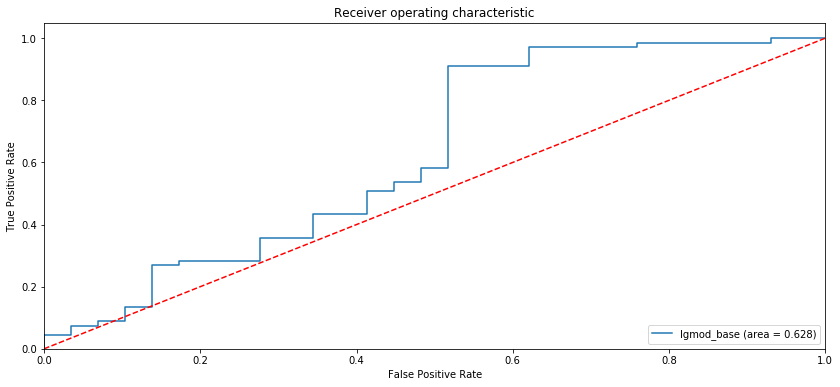

In [23]:
#area under curve for baseline. Plot of true positive rate against false positive rate
#.628 is bad, but the scaling helped improve the auc
y_pred_proba = lgmod_base.predict_proba(X_test)
preds = y_pred_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr,tpr)


plt.figure()
plt.plot(fpr, tpr, label='lgmod_base (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Gridsearch with pipeline(scaling, modeling)

In [9]:
X = df_nonull.drop(columns='Loan_Status_Y')
y = df_nonull['Loan_Status_Y']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=421)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((384, 12), (96, 12), (384,), (96,))

In [11]:
df_nonull.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Education_Not Graduate,Loan_Status_Y
1,1,4583,1508.0,128.0,360.0,1,1,0,1,0,0,0,0
2,0,3000,0.0,66.0,360.0,1,1,1,1,0,1,0,1
3,0,2583,2358.0,120.0,360.0,1,1,0,1,0,1,1,1
4,0,6000,0.0,141.0,360.0,1,0,0,1,0,1,0,1
5,2,5417,4196.0,267.0,360.0,1,1,1,1,0,1,0,1


In [38]:
warnings.filterwarnings("ignore")

logistic = LogisticRegression(max_iter = 200, random_state=421)
pipe = Pipeline([('scaler', MinMaxScaler()), ('logistic', logistic)])

solver_list = ['liblinear', 'lbfgs']
C = np.logspace(0,4,30)
penalty = ['none','l2','l1']

param_grid = [dict(logistic__solver = ['liblinear'], logistic__penalty = ['l1','l2'], logistic__C = C)
              , dict(logistic__solver = ['lbfgs'], logistic__penalty = ['none','l2'], logistic__C = C)]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=200,
                                                           multi_class='warn',
                                                           n

In [47]:
"test score = %3.2f" %(clf.score(X_test,y_test)), "train score = %3.2f" %(clf.score(X_train,y_train))

('test score = 0.77', 'train score = 0.82')

In [50]:
clf.best_score_

0.8125

In [45]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logistic',
                 LogisticRegression(C=12.689610031679221, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=200, multi_class='warn',
                                    n_jobs=None, penalty='l1', random_state=421,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [48]:
CV_result = cross_val_score(clf, X, y, cv=5)

In [49]:
CV_result

array([0.80412371, 0.78350515, 0.77083333, 0.86315789, 0.82105263])

In [53]:
#confusion matrix
cnf_matrix_base = metrics.confusion_matrix(y_test, clf.predict(X_test))
cnf_matrix_base

array([[11, 18],
       [ 4, 63]], dtype=int64)

In [54]:
#GridsearchCV model scores the same as the baseline??
print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(X_test)))
print("Precision:",metrics.precision_score(y_test, clf.predict(X_test)))
print("Recall:",metrics.recall_score(y_test, clf.predict(X_test)))

Accuracy: 0.7708333333333334
Precision: 0.7777777777777778
Recall: 0.9402985074626866


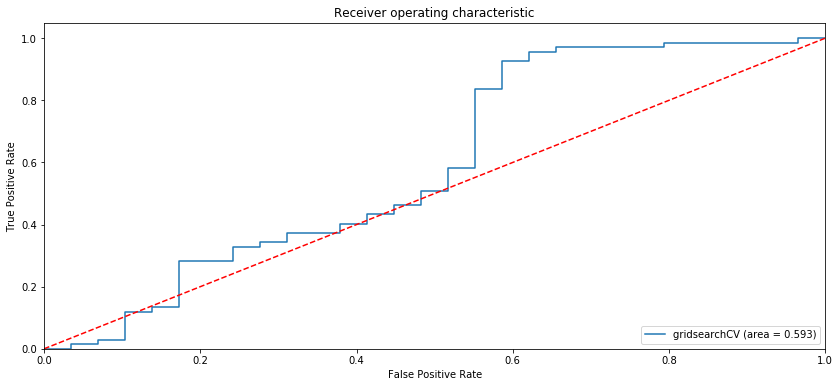

In [56]:
#area under curve for baseline. Plot of true positive rate against false positive rate
#.593 is worse than the baseline model auc.
y_pred_proba = clf.predict_proba(X_test)
preds = y_pred_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr,tpr)


plt.figure()
plt.plot(fpr, tpr, label='gridsearchCV (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Gridsearch with pipeline(scaling, PCA, modeling)

In [9]:
X = df_nonull.drop(columns='Loan_Status_Y')
y = df_nonull['Loan_Status_Y']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=421)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((384, 12), (96, 12), (384,), (96,))

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression())])

solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
C = np.logspace(-4,4,20)
penalty = ['l1','l2']

param_grid = [
    {solver=solver_list,
    penalty = penalty,
    C = C}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
clf.fit(X_train,y_train)

In [ ]:
print "score = %3.2f" %(grid.score(X_test,y_test))
print grid.best_params_

### K-NN

In [ ]:
X = df_nonull.drop(columns='Loan_Status_Y')
y = df_nonull['Loan_Status_Y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=421)

In [ ]:
KNNmod_base = KNeighborsClassifier(n_neighbors = 13, weights = 'uniform')
KNNmod_base.fit(X_train, y_train)
y_base_pred = KNNmod_base.predict(X_test)

In [ ]:
#confusion matrix N= 13
cnf_matrix_base = metrics.confusion_matrix(y_test, y_base_pred)
cnf_matrix_base

In [ ]:
#neighbors = 5
print("Accuracy:",metrics.accuracy_score(y_test, y_base_pred))
print("Precision:",metrics.precision_score(y_test, y_base_pred))
print("Recall:",metrics.recall_score(y_test, y_base_pred))

In [ ]:
#neighbors = 9
print("Accuracy:",metrics.accuracy_score(y_test, y_base_pred))
print("Precision:",metrics.precision_score(y_test, y_base_pred))
print("Recall:",metrics.recall_score(y_test, y_base_pred))

In [ ]:
#neighbors = 13
print("Accuracy:",metrics.accuracy_score(y_test, y_base_pred))
print("Precision:",metrics.precision_score(y_test, y_base_pred))
print("Recall:",metrics.recall_score(y_test, y_base_pred))

In [ ]:
#neighbors = 13
print("Accuracy:",metrics.accuracy_score(y_train, KNNmod_base.predict(X_train)))
print("Precision:",metrics.precision_score(y_train, KNNmod_base.predict(X_train)))
print("Recall:",metrics.recall_score(y_train, KNNmod_base.predict(X_train)))

In [ ]:
#create DataFrame to store accuracy, precision, recall
#create loop for neighbors range (1,19) and save scores into DataFrame

In [ ]:
#Grid search CV
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params = dict(solver=solver_list)
log_reg = LogisticRegression(C=1, n_jobs=-1, random_state=34)
clf = GridSearchCV(log_reg, params, cv=5)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']

for score, solver in zip(scores, solver_list):
    print(f"  {solver} {score:.3f}" )

# Normalization

In [ ]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Encode and Impute

In [ ]:
encoder = OrdinalEncoder()
imputer = SimpleImputer()

In [ ]:
df = loan.copy()

In [ ]:
loan.head(20)

## Fill with test statistic (mean or mode)

In [ ]:
from sklearn.impute import SimpleImputer
#from sklearn.impute import KNNImputer
#Can't import KNN imputer for some reason

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy='mean')
imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')

In [ ]:
mean_value=train['Age'].mean()
train['Age']=train['Age'].fillna(mean_value)

In [ ]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(train)
train= imp.transform(train)

## Impute with pipeline

## KNN imputation

In [ ]:
#choose mode of k labels
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3, weights='distance')

In [ ]:
Inst

## APENDIX

In [ ]:
#Don't use ordinalencoder because it might screw up the ordinality of your data. 
#For something simple like this, just replace the 3+ with 3.
cat_cols = ['Dependents']

def encode(df):
    nonulls = np.array(df.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    df.loc[df.notnull()] = np.squeeze(impute_ordinal)
    return df

for col in cat_cols:
    encode(df[col])
    
df.head(20)

In [ ]:
#identifying the best solver
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params = dict(solver=solver_list)
log_reg = LogisticRegression(C=1, n_jobs=-1, random_state=34)
clf = GridSearchCV(log_reg, params, cv=5)
clf.fit(X_train, y_train)

In [ ]:
#confusion matrix
cnf_matrix_base = metrics.confusion_matrix(y_test, y_base_pred)
cnf_matrix_base

In [ ]:
#Grid search CV
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params = dict(solver=solver_list)
log_reg = LogisticRegression(C=1, n_jobs=-1, random_state=34)
clf = GridSearchCV(log_reg, params, cv=5)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']

for score, solver in zip(scores, solver_list):
    print(f"  {solver} {score:.3f}" )

In [ ]:
#pipeline for feature extraction and modeling
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', LogisticRegression()))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

In [ ]:
#Credit_history is the strongest correlation to Loan status, makes sense.

mask = np.zeros_like(df_nonull.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

plt.figure(figsize=(10,10))
plt.title("Loan Feature Correlation Matrix", fontsize=30)
x = sns.heatmap(
    df_nonull.corr(), 
    cmap='coolwarm',
    annot=True,
    mask=mask,
    linewidths = .5,
    vmin = -1, 
    vmax = 1,
)

In [ ]:
#area under curve for baseline. Plot of true positive rate against false positive rate
y_pred_proba = lgmod_base.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()